In [16]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# import pyproj
from shapely.ops import transform
import xarray as xr
import numpy as np
import matplotlib as mpl
from scipy.ndimage import binary_dilation as dilate
import scipy as sp
import datetime
# from cartopy.feature.nightshade import Nightshade
import os
SMALL_SIZE = 20
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [79]:
data_path = 'D:\\data\\SEASTAR\\SEASTARSciRec\\Data\\CoSMIZ\\'
ds_coast = xr.open_dataset(data_path + 'SeaSTAR_coastal_mask_20220502.nc')
# ds_ice_N = xr.open_dataset(data_path + 'ice_conc_nh_ease2-250_cdr-v2p0_201409191200.nc')
ds_ice_N = xr.open_dataset(data_path + 'ice_conc_nh_ease2-250_cdr-v2p0_197902271200.nc')
ds_ice_S = xr.open_dataset(data_path + 'ice_conc_sh_ease2-250_cdr-v2p0_201409191200.nc')
ds_new = xr.open_dataset(data_path + '2023.04.26 ESA generated_Seastar_mask_summer.nc')

C:\Users\davidmccann\AppData\Local\Temp\ipykernel_15520\394342969.py:4: DeprecationWarning: Please use `binary_fill_holes` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  SIB_5_SH = xr.DataArray(data=sp.ndimage.morphology.binary_fill_holes(SIB_5_SH.isel(time=0)).astype('int'),


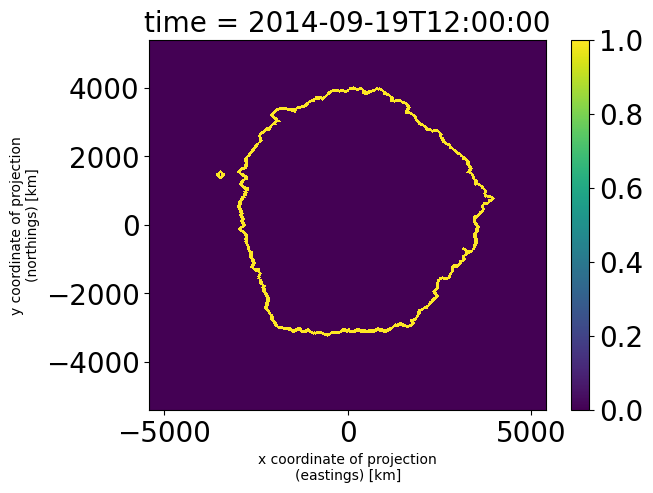

In [80]:
land = xr.where(np.isnan(ds_ice_S.ice_conc),True,False)
# SIB_5_SH = land.where(ds_ice_S.ice_conc>5,0,1)
SIB_5_SH = xr.where(ds_ice_S.ice_conc>5, 1, 0)
SIB_5_SH = xr.DataArray(data=sp.ndimage.morphology.binary_fill_holes(SIB_5_SH.isel(time=0)).astype('int'),
             dims=SIB_5_SH.isel(time=0).dims,
             coords=SIB_5_SH.isel(time=0).coords)
# SIB_5_SH = xr.where(land, 0, SIB_5_SH)
SIB_5_SH = dilate(SIB_5_SH.data, iterations=4) - SIB_5_SH
# SIB_5_SH = dilate(sp.ndimage.binary_fill_holes(SIB_5_SH.isel(time=0)), iterations=4) - SIB_5_SH.isel(time=0)
SIB_5_SH.plot()
# land, SIB_5_SH = xr.align(land, SIB_5_SH, join='outer')
# SIB_5_SH = xr.where(SIB_5_SH>0, 1, 0)
# xr.where(land, SIB_5_SH, 0).plot()
# plt.show()



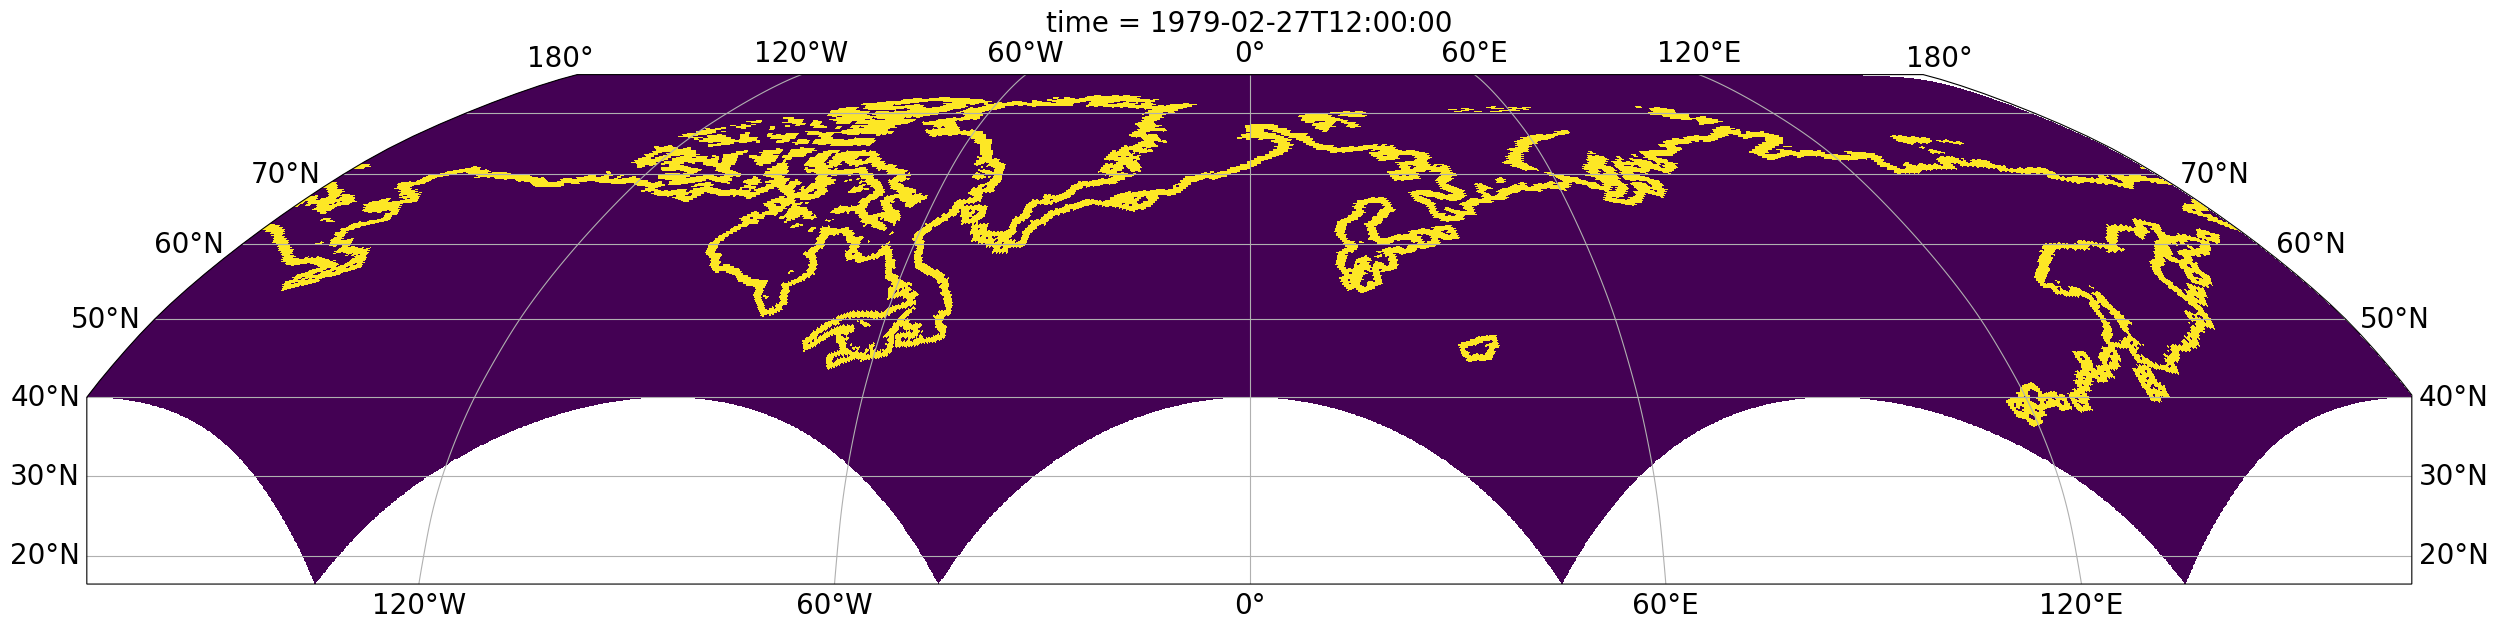

In [81]:

land = xr.where(np.isnan(ds_ice_N.ice_conc),True,False)
# SIB_5_SH = land.where(ds_ice_S.ice_conc>5,0,1)
SIB_5_NH = xr.where(ds_ice_N.ice_conc>5, 1, 0)
SIB_5_NH = xr.where(land, 0, SIB_5_NH)
SIB_5_NH = dilate(SIB_5_NH.isel(time=0).data, iterations=4) - SIB_5_NH.isel(time=0)
lakes=dict()
lakes[1] = [-95,-75,40,50] # Great Lakes
lakes[2] = [-105,-95,50,55] # Great Lakes
lakes[3] = [-120,-105,55,64] # Great Lakes
lakes[4] = [-125,-115,63.5,67.5] # Great Lakes
lakes[5] = [100,112,50,57] # Baikal
lakes[6] = [45,55,35,50] # Caspian Sea
lat = SIB_5_NH.lat
lon = SIB_5_NH.lon
for i in lakes.keys():   
    SIB_5_NH = xr.where((lon > lakes[i][0]) & (lon < lakes[i][1])
              & (lat > lakes[i][2]) & (lat < lakes[i][3]),
         False,
         SIB_5_NH
        )

plt.figure(figsize=(30, 10))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=0, globe=None))
SIB_5_NH.plot(x='lon',y='lat',transform=ccrs.PlateCarree(), add_colorbar=False)
# ax.set_extent([30,60,30,60], crs=ccrs.PlateCarree())
gl=ax.gridlines(draw_labels=True)
# xr.where(ds_ice_N.ice_conc>5, 1, 0).plot()

In [82]:
SIB_5_SH['lat'] = ds_ice_S.lat
SIB_5_SH['lon'] = ds_ice_S.lon

SIB_5_NH['lat'] = ds_ice_N.lat
SIB_5_NH['lon'] = ds_ice_N.lon

In [83]:
ds_coast['mask'] = xr.where((ds_coast.mask.lat > 35) & (ds_coast.mask.lat < 50)
         & (ds_coast.mask.lon > 45) & (ds_coast.mask.lon < 55),
         False,
         ds_coast.mask)
ds_coast['mask'] = xr.where((ds_coast.mask.lat < -60),
            False,
            ds_coast.mask)

In [84]:
combined_mask = ds_coast.mask.copy(deep=True)
for i_lat, latitude in enumerate(SIB_5_SH.lat):
    for i_lon, longitude in enumerate(SIB_5_SH.lon):
        if SIB_5_SH[i_lat,i_lon]:
            lo = SIB_5_SH.lon[i_lat,i_lon].data
            la = SIB_5_SH.lat[i_lat,i_lon].data
            abslat = np.abs(combined_mask.lat-la)
            abslon = np.abs(combined_mask.lon-lo)
            c = np.maximum(abslat, abslon)
            #([xloc], [yloc]) = np.where(c == np.min(c))
            combined_mask[np.where(c == np.min(c))] = 1

In [85]:
for i_lat, latitude in enumerate(SIB_5_NH.lat):
    for i_lon, longitude in enumerate(SIB_5_NH.lon):
        if SIB_5_NH[i_lat,i_lon]:
            lo = SIB_5_NH.lon[i_lat,i_lon].data
            la = SIB_5_NH.lat[i_lat,i_lon].data
            abslat = np.abs(combined_mask.lat-la)
            abslon = np.abs(combined_mask.lon-lo)
            c = np.maximum(abslat, abslon)
            #([xloc], [yloc]) = np.where(c == np.min(c))
            combined_mask[np.where(c == np.min(c))] = 1

In [86]:
combined_mask.to_netcdf(data_path + 'CoSMIZ_mask_20230713.nc')

In [75]:
combined_mask = xr.open_dataset(data_path + 'CoSMIZ_mask_20230713.nc')

In [87]:
combined_mask = combined_mask.mask

AttributeError: 'DataArray' object has no attribute 'mask'

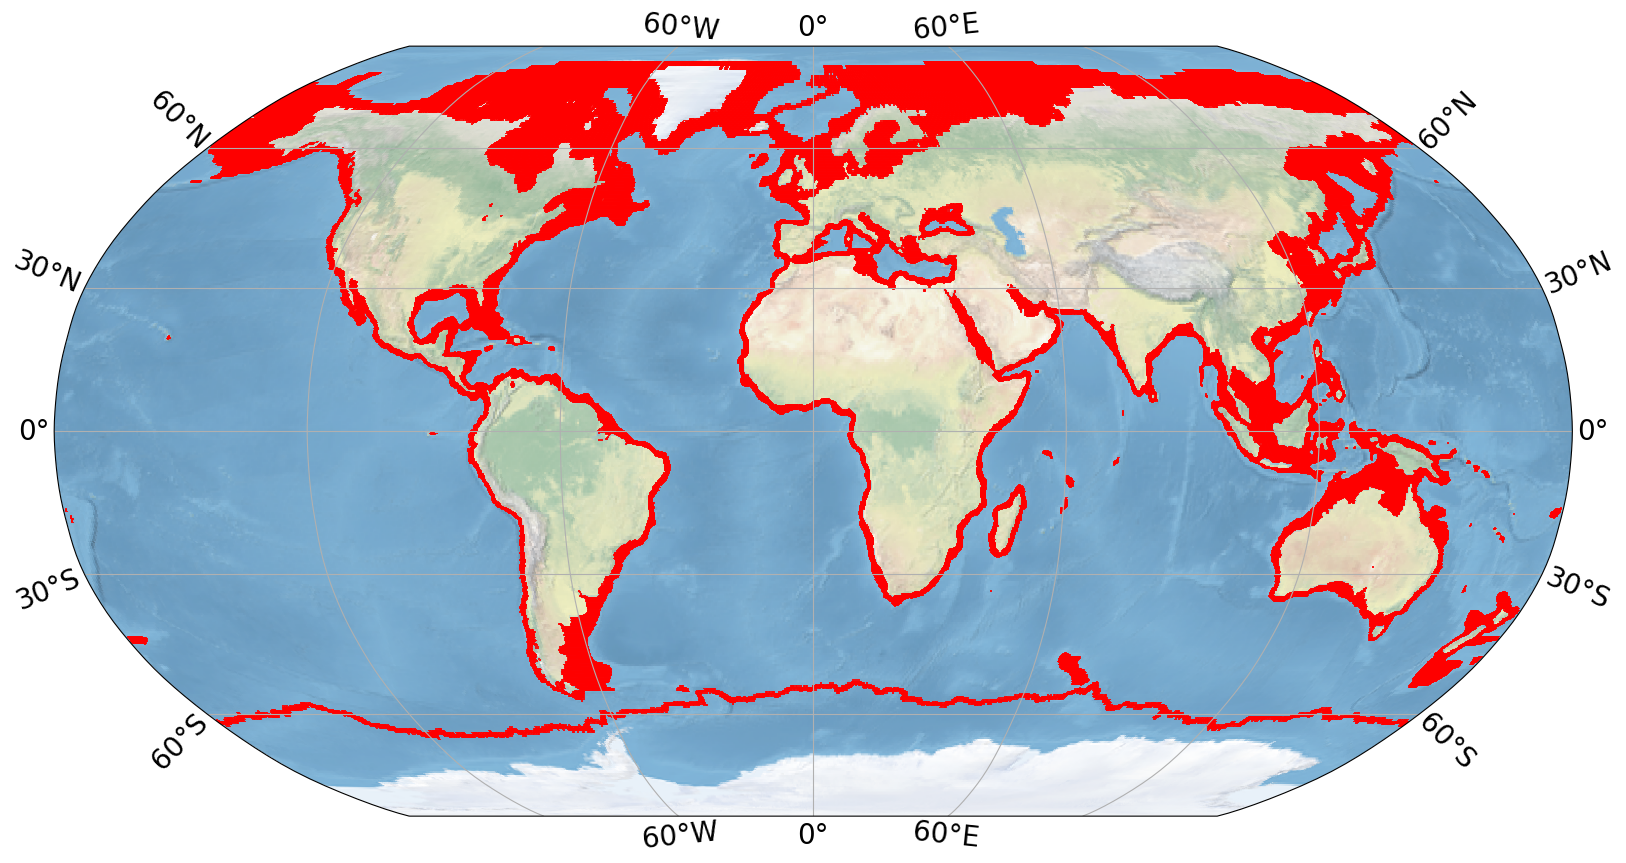

In [12]:
colors=['r']
plt.figure(figsize=(30, 10))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=0, globe=None))

combined_mask.astype(float).plot(alpha=sp.ndimage.binary_closing(combined_mask).astype(float) * 0.9,
                                 cmap=mpl.colors.ListedColormap(colors),add_colorbar=False,
                                transform=ccrs.PlateCarree())
ax.stock_img()
gl=ax.gridlines(draw_labels=True)
# plt.savefig(os.path.join(r'D:\OneDrive - NERC\OneDrive - NERC\SEASTAR\SeastarEx\paper\figures\misc\CoSMIZ',
#                         'CoSMIZ_Robinson.tiff'), dpi=100, bbox_inches='tight', transparent=True)

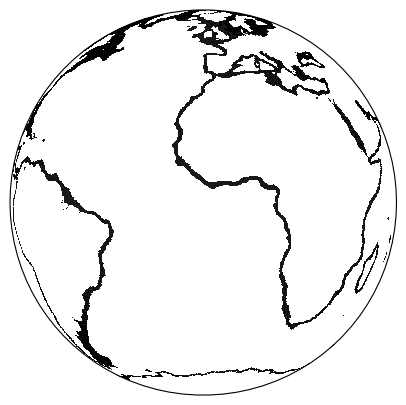

In [27]:
colors=['k']
plt.figure(figsize=(5, 5))
# ax = plt.axes(projection=ccrs.Orthographic(central_longitude=-10,
#                                            central_latitude=5,
#                                            globe=None))

ax = plt.axes(projection=ccrs.Geostationary(central_longitude=-10.0, satellite_height=35785831, false_easting=0, false_northing=0, globe=None))

combined_mask.astype(float).plot(alpha=sp.ndimage.binary_closing(combined_mask).astype(float) * 0.9,
                                 cmap=mpl.colors.ListedColormap(colors),add_colorbar=False,
                                transform=ccrs.PlateCarree())
# ax.stock_img()
plt.savefig(os.path.join(r'D:\OneDrive - NERC\OneDrive - NERC\SEASTAR\SeastarEx\paper\figures\misc\CoSMIZ',
                        'CoSMIZ_globe_geostationary_010W_000N_B&W_600dpi.tiff'), dpi=600, bbox_inches='tight', transparent=True)


# date = datetime.datetime(2023, 12, 21, 15)
# ax.add_feature(Nightshade(date, alpha=0.3))

In [103]:
globe.Band1

<xarray.DataArray 'Band1' (lat: 10800, lon: 21600)>
[233280000 values with dtype=uint8]
Coordinates:
  * lat      (lat) float64 -89.99 -89.97 -89.96 -89.94 ... 89.96 89.97 89.99
  * lon      (lon) float64 -180.0 -180.0 -180.0 -179.9 ... 180.0 180.0 180.0
Attributes:
    long_name:     GDAL Band Number 1
    valid_range:   [  0 255]
    grid_mapping:  crs

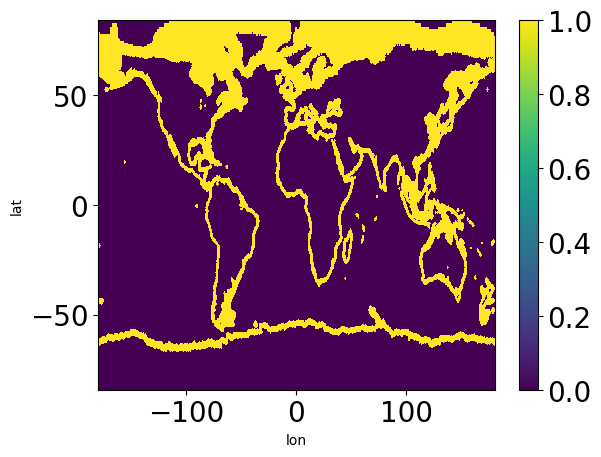

In [64]:
xr.DataArray(data=dilate(combined_mask.data, iterations=3),
                           dims=combined_mask.dims,
                           coords=combined_mask.coords).plot()


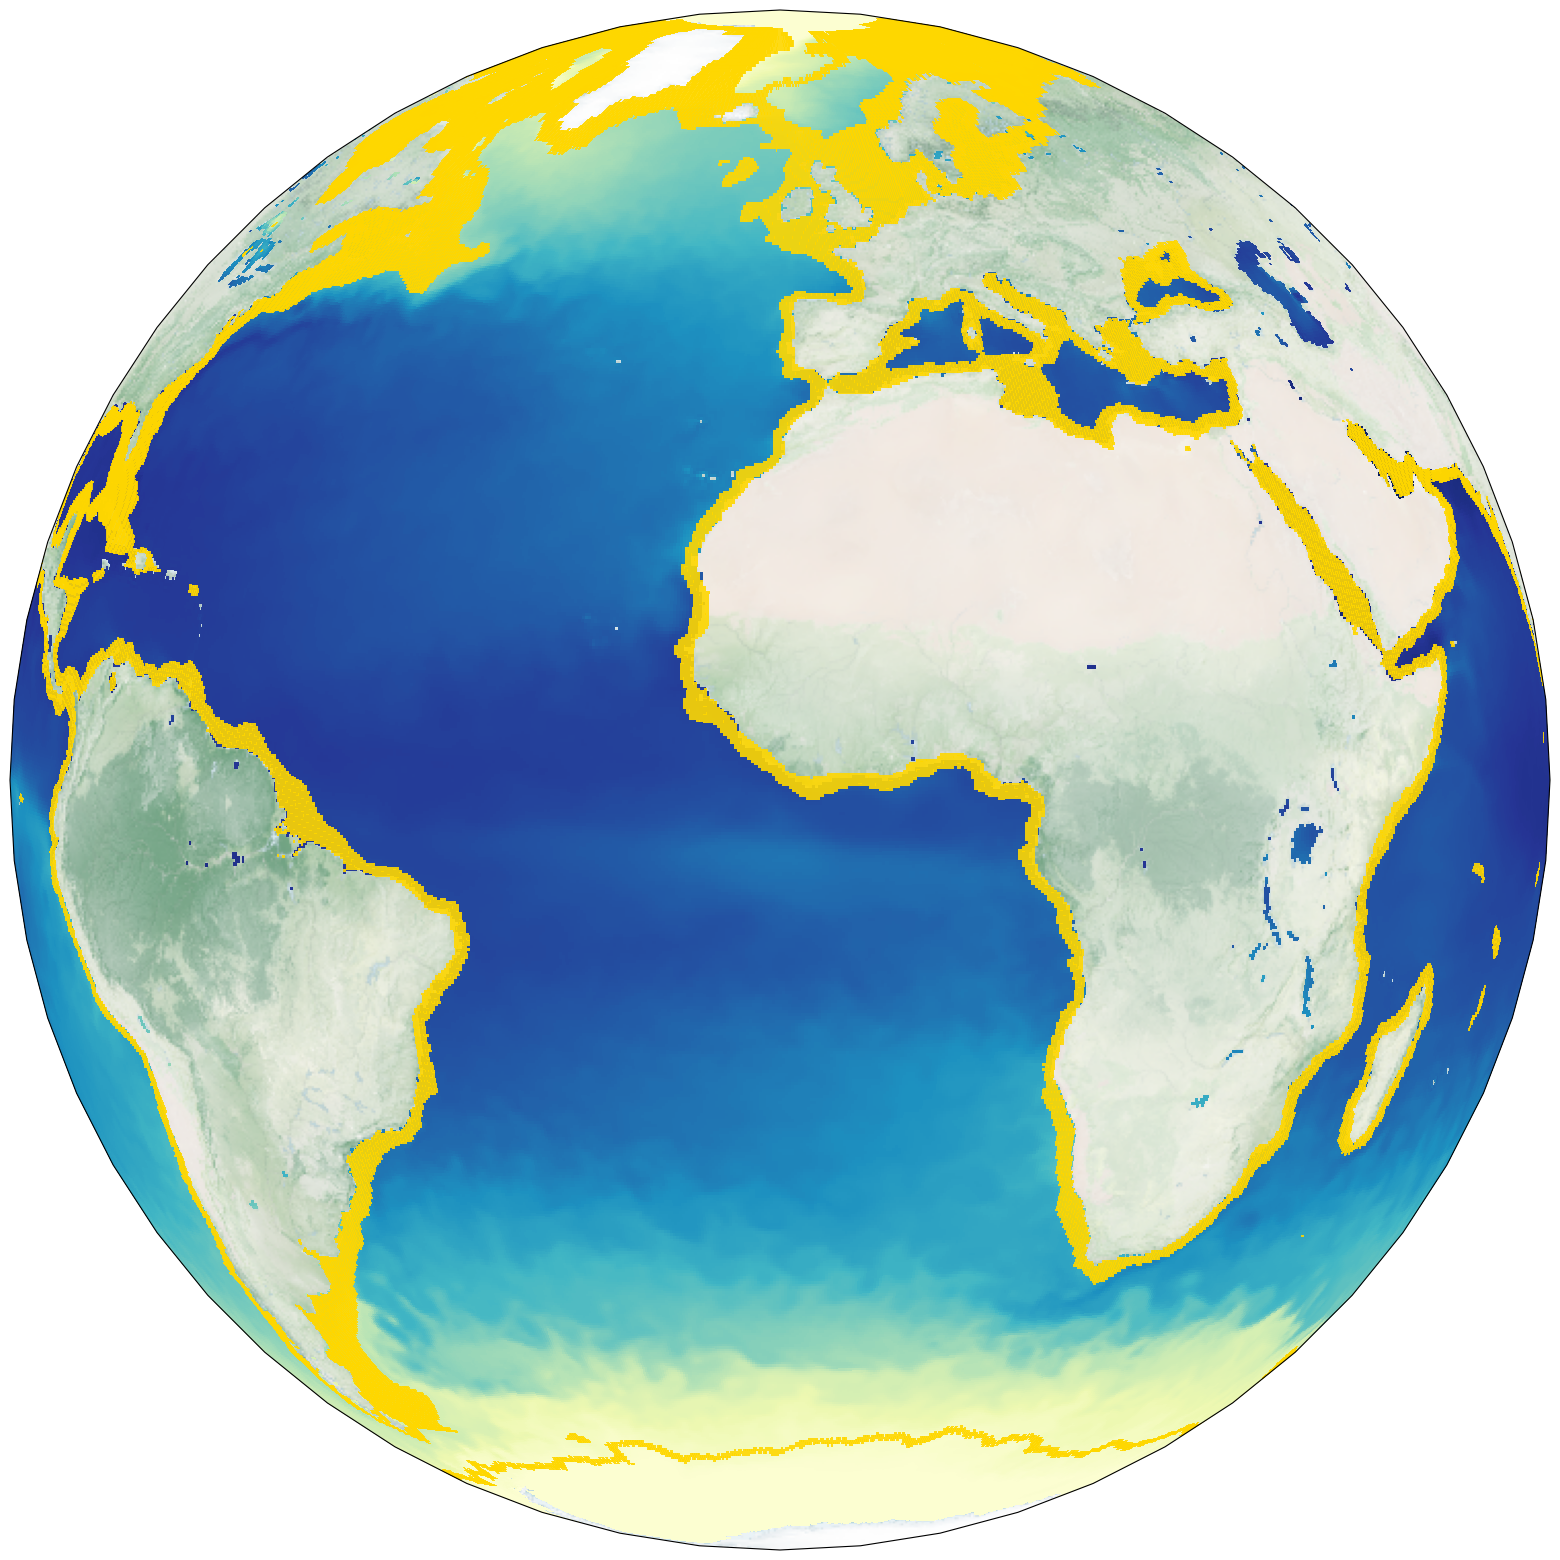

In [90]:
colors=['gold']

combined_mask = xr.open_dataset(data_path + 'CoSMIZ_mask_20230713.nc')
combined_mask = combined_mask.mask

plt.figure(figsize=(20, 20))
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=-10,
                                           central_latitude=5,
                                           globe=None))
globe = xr.open_dataset(data_path + 'globe.nc')
c_factor = 10
globe2 = globe.coarsen(lat=c_factor,boundary='trim').mean().coarsen(lon=c_factor,boundary='trim').mean()

R = globe2.Band1.astype('uint8')
G = globe2.Band2.astype('uint8')
B = globe2.Band3.astype('uint8')
# R = globe.Band1
# G = globe.Band2
# B = globe.Band3

RGB = np.dstack([R, G, B])

ax.imshow(RGB,transform=ccrs.PlateCarree(),origin='lower')
sst.isel(time=0).sst.plot(transform=ccrs.PlateCarree(),
                         add_colorbar=False,
                         cmap='YlGnBu')
plt.title('')

dilated_mask.astype(float).plot(alpha=sp.ndimage.binary_closing(combined_mask).astype(float) * 0.9,
                                 cmap=mpl.colors.ListedColormap(colors),add_colorbar=False,
                                transform=ccrs.PlateCarree())
# combined_mask.astype(float).plot(cmap=mpl.colors.ListedColormap(colors),add_colorbar=False,
#                                 transform=ccrs.PlateCarree())
# plt.savefig(os.path.join(r'D:\OneDrive - NERC\OneDrive - NERC\SEASTAR\SeastarEx\paper\figures\misc\CoSMIZ',
#                          'CoSMIZ_globe_010W_005N_with_Mask_NASA_EO_Basemap_SST_600dpi.png'),
#             dpi=600,
#             bbox_inches='tight',
#             transparent=True)
# combined_mask.astype(float).plot(alpha=sp.ndimage.binary_closing(combined_mask).astype(float) * 0.9,
#                                  cmap=mpl.colors.ListedColormap(colors),add_colorbar=False,
#                                 transform=ccrs.PlateCarree())
# RGB.plot(transform=ccrs.PlateCarree(),
#                   cmap='Greens',
#                   alpha=0.3,
#                   add_colorbar=False,
#      )


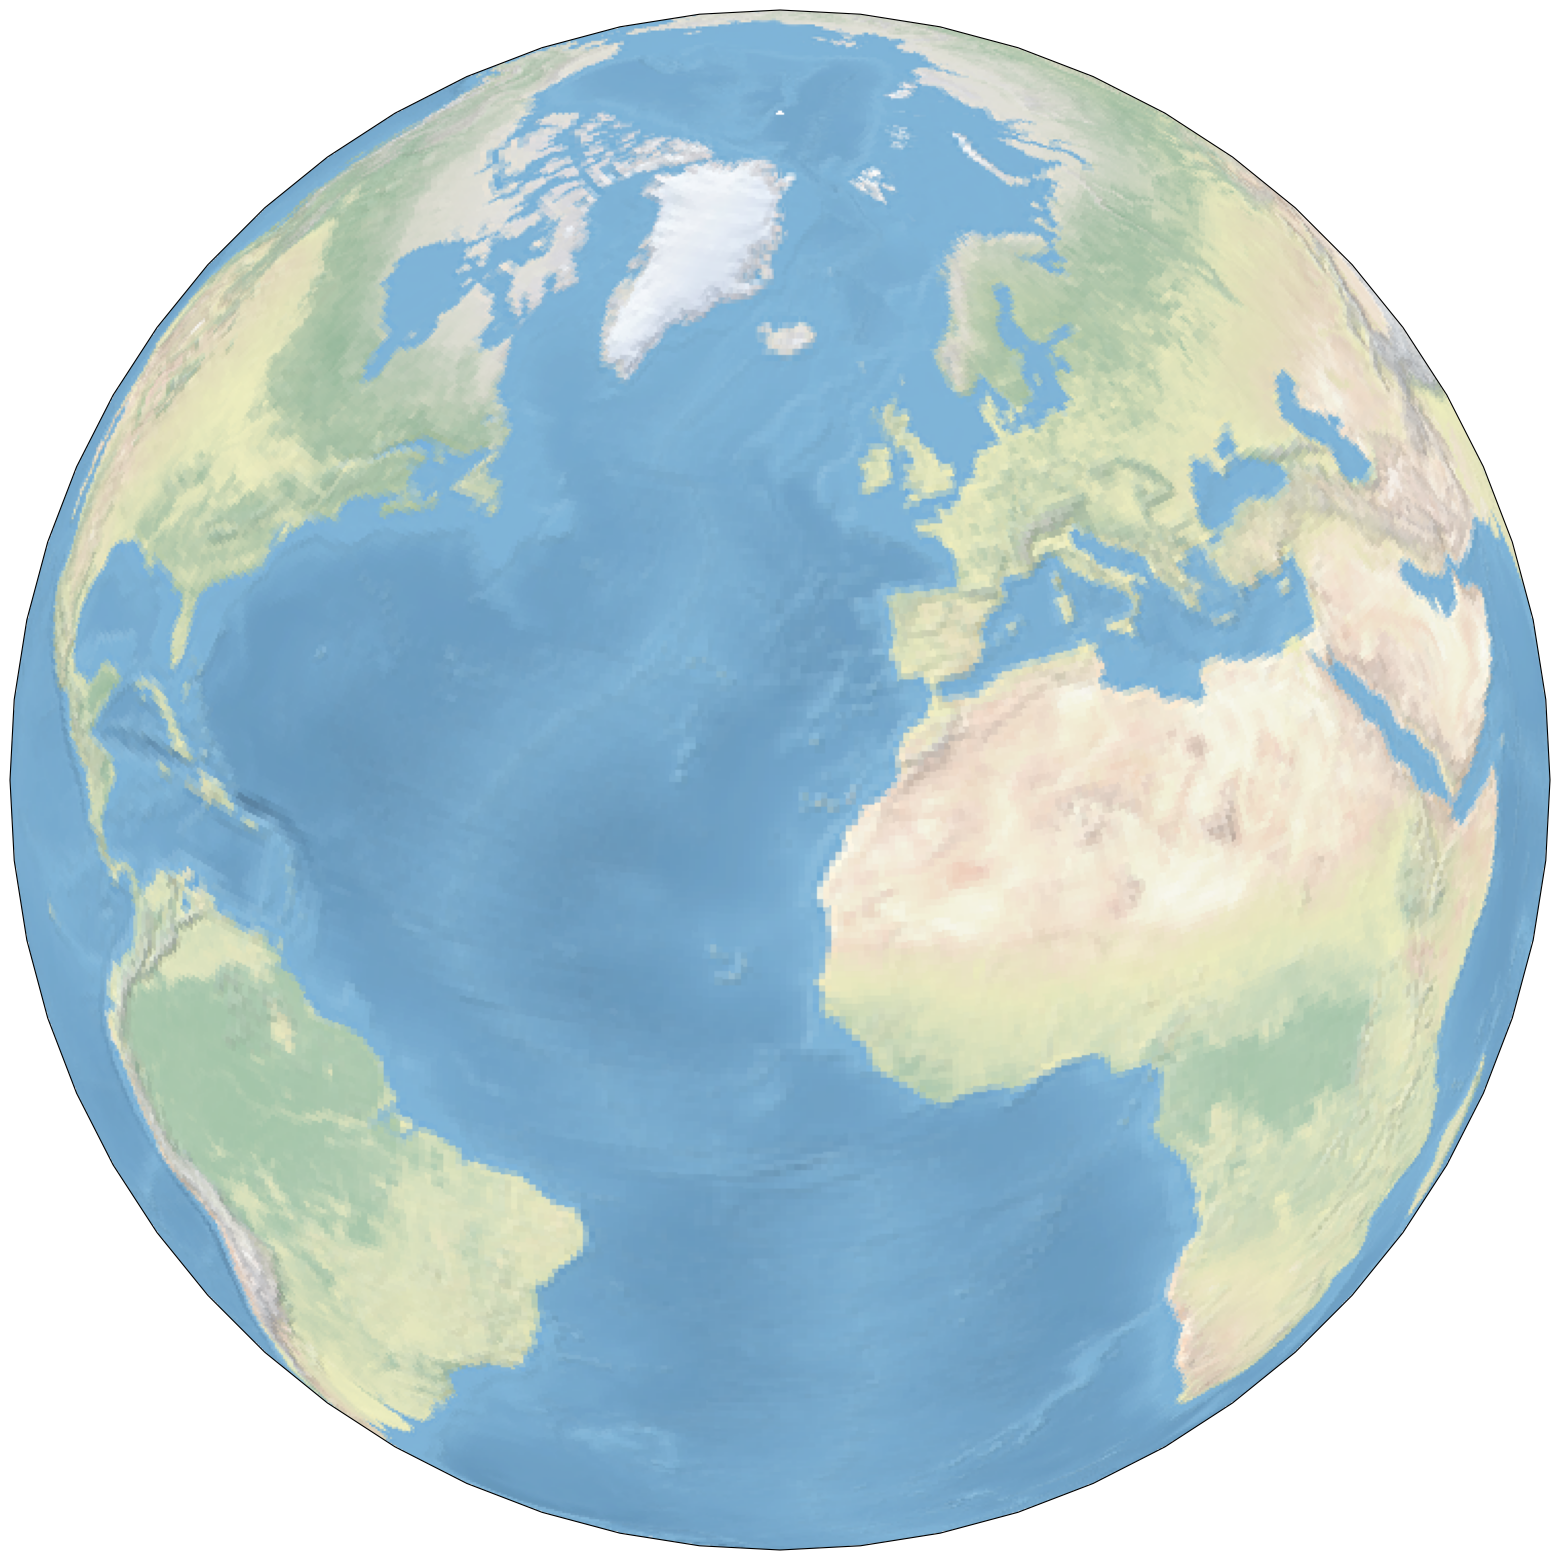

In [23]:
colors=['k']
plt.figure(figsize=(20, 20))
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=-20,
                                           central_latitude=30,
                                           globe=None))

# combined_mask.astype(float).plot(alpha=sp.ndimage.binary_closing(combined_mask).astype(float) * 1,
#                                  cmap=mpl.colors.ListedColormap(colors),add_colorbar=False,
#                                 transform=ccrs.PlateCarree())
ax.stock_img()
# plt.savefig(os.path.join(r'D:\OneDrive - NERC\OneDrive - NERC\SEASTAR\SeastarEx\paper\figures\misc\CoSMIZ',
#                         'CoSMIZ_globe_020W_030N_noMask_600dpi.tiff'), dpi=600, bbox_inches='tight', transparent=True)

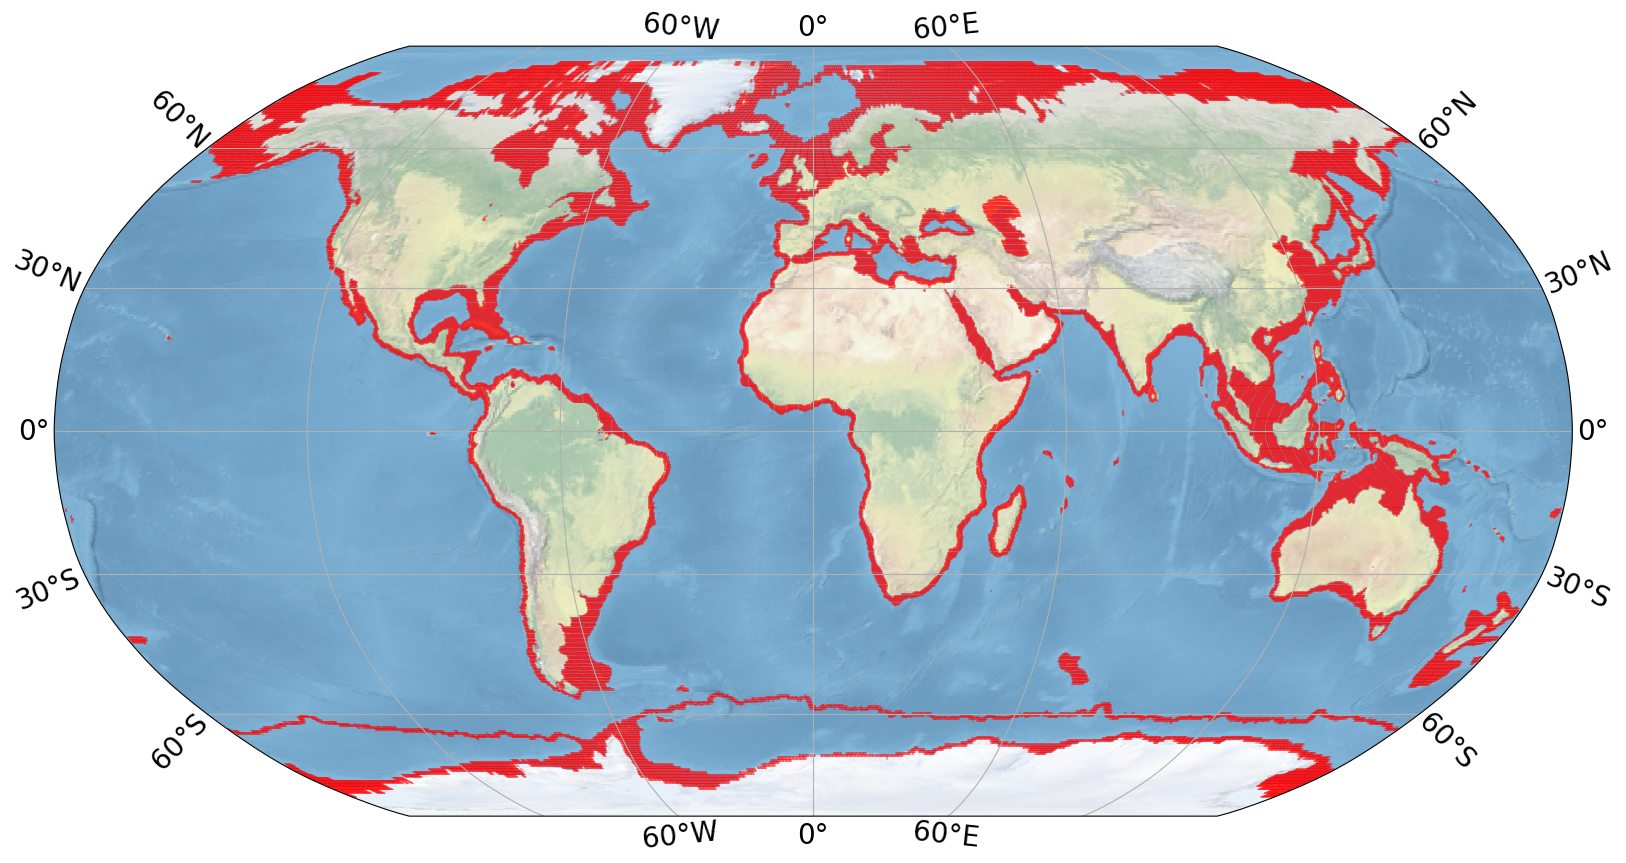

In [18]:
combined_mask = (ds_new.mask.astype('bool') + ds_coast.mask)
colors=['r']
plt.figure(figsize=(30, 10))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=0, globe=None))

combined_mask.astype(float).plot(alpha=sp.ndimage.binary_closing(combined_mask).astype(float) * 0.3,
                                 cmap=mpl.colors.ListedColormap(colors),add_colorbar=False,
                                transform=ccrs.PlateCarree())
ax.stock_img()
gl=ax.gridlines(draw_labels=True)


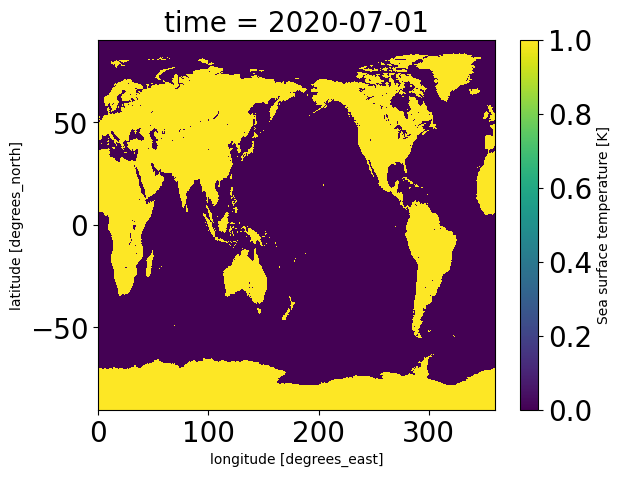

In [35]:
sst = xr.open_dataset(data_path+'sst.nc')
xr.where(sst.isel(time=0).sst

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 3)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2020-07-01 2021-07-01 2022-07-01
Data variables:
    sst        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-09-05 14:42:53 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

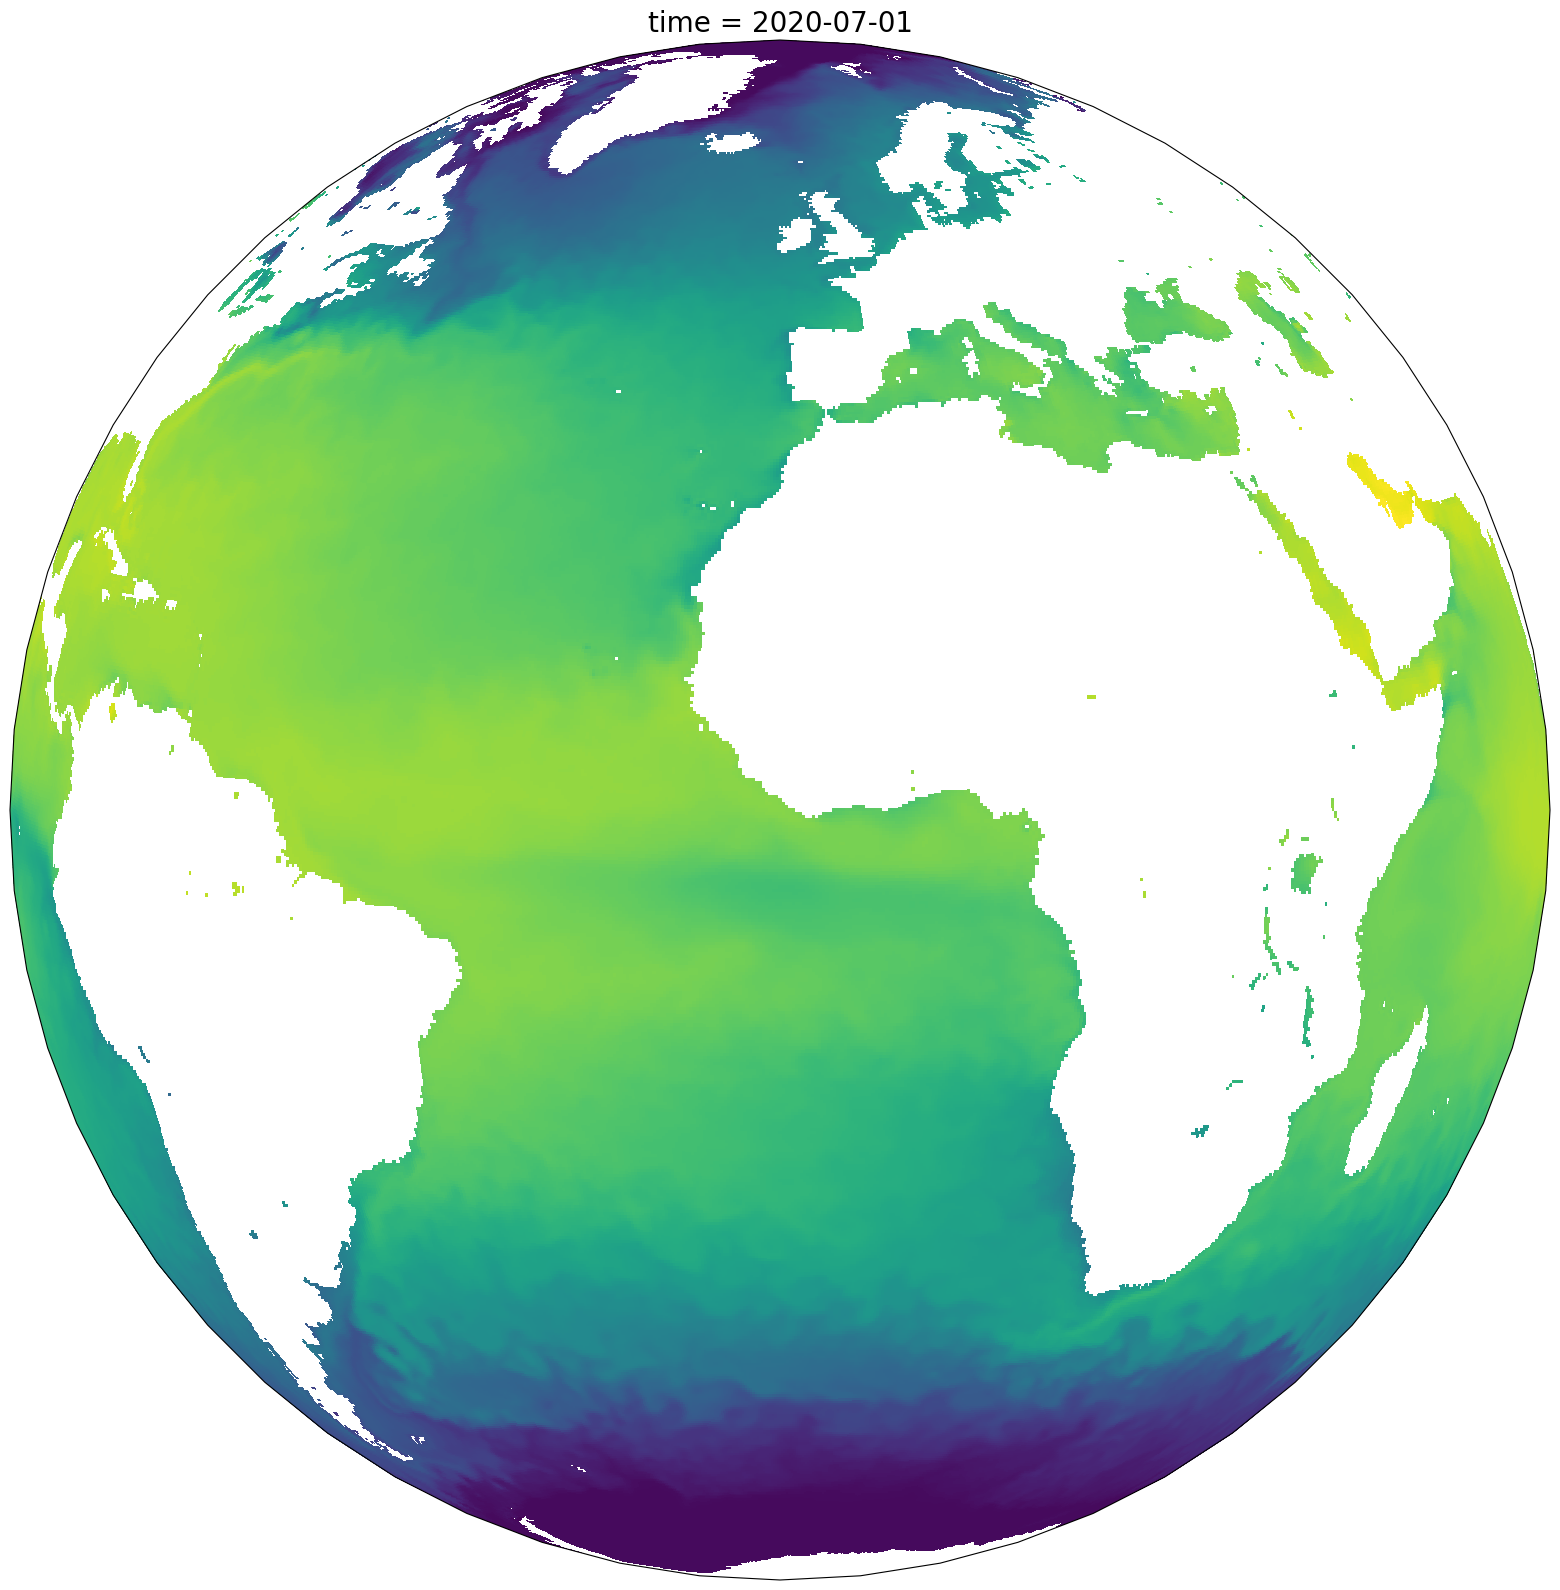

In [34]:
plt.figure(figsize=(20, 20))
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=-10,
                                           central_latitude=5,
                                           globe=None))
sst.isel(time=0).sst.plot(transform=ccrs.PlateCarree(),
                         add_colorbar=False)